In [1]:
# all required libraries 

from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats


# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# model

from  sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


# performance evaluation
from sklearn.metrics import r2_score, mean_squared_error


# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/CHANG/Anaconda3/Lib/site-packages'
import graphviz

# 從Google Drive載入數據

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Variables dataframe是我手動根據data description的variables的性質分類。0 == nominal, 1 == ordinal, 3 == number/time

In [3]:
# 檔名若是中文會報錯


traindf = pd.read_csv('/content/drive/My Drive/Untitled folder/House Price Prediction /dataset/train.csv')
testdf = pd.read_csv('/content/drive/My Drive/Untitled folder/House Price Prediction /dataset/test.csv')


# variables: 0 == nominal, 1 == ordinal, 3 == number/time
variables = pd.read_excel('/content/drive/My Drive/Untitled folder/House Price Prediction /dataset/variables_type.xlsx', header=None)


## Variables的性質

In [4]:
variables.columns = ['val', 'datatype']

In [5]:
variables.head()

,val,datatype
0,MSSubClass,0
1,MSZoning,0
2,LotFrontage,3
3,LotArea,3
4,Street,0


以下的Variables 在train df跟在variables df名稱不一樣。

In [6]:
# Bedroom == BedroomAbvGr
# Kitchen == KitchenAbvGr
# datatype of 'BedroomAbvGr', 'KitchenAbvGr' in variables df are correct, both are numbers 



variables[variables.val.apply(lambda x: x in ['Bedroom', 'Kitchen'])]

,val,datatype
50,Bedroom,3
51,Kitchen,3


In [7]:
# Let's take a look at  'BedroomAbvGr', 'KitchenAbvGr'
traindf[['BedroomAbvGr', 'KitchenAbvGr']].head()

,BedroomAbvGr,KitchenAbvGr
0,3,1
1,3,1
2,3,1
3,3,1
4,4,1


以下的Variables 在train df跟在variables df名稱不一樣。(出現在train df但沒有在 variables df)

In [8]:
print([val for val in list(traindf.columns) if val not in list(variables.val)])

['Id', 'BedroomAbvGr', 'KitchenAbvGr', 'SalePrice']


# EDA

Training dataset: 1460間房，81個特徵  
Test dataset: 1459間房，80個特徵

In [9]:
print('Training dataset', traindf.shape)
print('Test dataset', testdf.shape)

Training dataset (1460, 81)
Test dataset (1459, 80)


合併Training& Test dataset, 除去此項目的預測目標, "SalePrice"。  
合併後的df有80個特徵，2919間房。

In [10]:
train_test = pd.concat([traindf.loc[:, :'SaleCondition'],testdf], axis = 0 ).reset_index()

print(train_test.shape)
train_test.head()

(2919, 81)


,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,...,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,...,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,...,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,...,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,...,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [11]:
train_test = train_test.drop(columns='index')

## 缺失值

In [12]:
## Missing percentage

alldf_missing = pd.DataFrame(train_test.isnull().sum()).reset_index()

alldf_missing.columns = ['variable', 'NA']

alldf_missing = alldf_missing.sort_values(by = 'NA', ascending= False)

alldf_missing['percentage'] = (alldf_missing['NA']/ 2919) * 100

此處將缺失值大於45%的columns(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])去除。

In [13]:
print('We drop {} columns because those columns have more than or almost 50% NA data'.format(list(alldf_missing[alldf_missing.percentage > 45].variable)))

print('\n')
print('There are {} variables having missing values in dataset.'.format(alldf_missing[alldf_missing.NA != 0].shape[0]))
alldf_missing[alldf_missing.NA != 0]

We drop ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'] columns because those columns have more than or almost 50% NA data


There are 34 variables having missing values in dataset.


,variable,NA,percentage
72,PoolQC,2909,99.657417
74,MiscFeature,2814,96.402878
6,Alley,2721,93.216855
73,Fence,2348,80.438506
57,FireplaceQu,1420,48.646797
3,LotFrontage,486,16.649538
59,GarageYrBlt,159,5.447071
60,GarageFinish,159,5.447071
63,GarageQual,159,5.447071
64,GarageCond,159,5.447071


In [14]:
train_test.drop(columns= ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], inplace=True )

### 找出缺失值可能原因，然後填補缺失值

對於numerical空值，用-99/ median/ 0，根據可能原因填補。  
對於categoical空值，用'NA'填補。

In [15]:
# visualizing a column with hist graph
 
def var_distribution(column = None, df = None):
    
    null = (train_test[column].isnull().sum()/ train_test.shape[0])*100
    print(column, 'has {:.2f}% null values.'.format(null))

    plt.figure(figsize=(10, 5))
    plt.suptitle(column)



    plt.subplot(1, 2, 1)
    df[column].plot(kind = 'hist', bins = 50)
    
    
    plt.subplot(1, 2, 2)
    df.boxplot(column = column)

    

    plt.show()
    


In [16]:
def counts_and_nulls(df, column):

  print('Null values percentage: {:.2f}'.format( df[column].isnull().sum()/ df.shape[0]))

  sns.countplot(data = df, x = column )
  plt.show()

#### LotFrontage

用中間值填補缺失值。(用負值試試看)

LotFrontage has 16.65% null values.


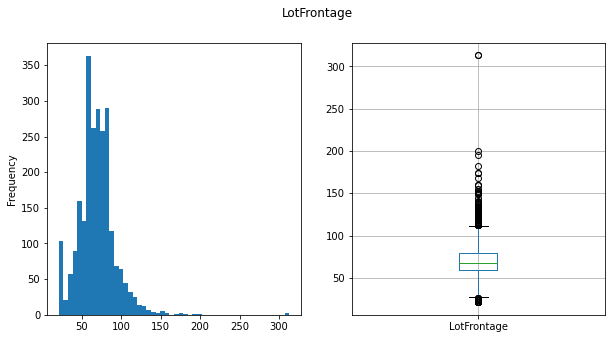

In [17]:
var_distribution(column= 'LotFrontage', df=train_test)

In [18]:
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(-99)

In [19]:
# print("LotFrontage's median", train_test['LotFrontage'].median())



#### GarageYrBlt

從下圖可以看出此項目的房子，約建於 1895 ~ 2010年。

GarageYrBlt has 5.45% null values.


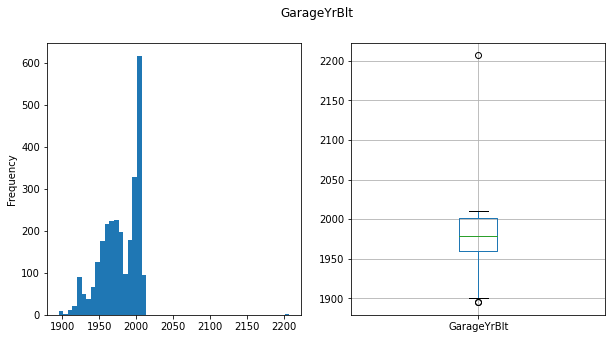

In [20]:
var_distribution(column= 'GarageYrBlt', df=train_test)

有一個異常值，GarageYrBlt > 2200，這個異常值在testdf，以房屋建造年進行修改。

In [21]:
list(train_test[train_test.GarageYrBlt>2200].Id).pop() in list(testdf.Id)

True

In [22]:
train_test.loc[2592, 'GarageYrBlt'] = 2006

GarageYrBlt有空值可能跟房屋沒有GarageYrBlt有關係。  
因為99%的GarageYrBlt空值，GarageArea都是0。  
所以用-99填補空值。

In [23]:
GarageYrBlt_null = train_test.GarageYrBlt.isnull().sum()

print('The number of houses that GarageYrBlt is null and GarageArea is 0 :', train_test[(train_test.GarageYrBlt.isnull())& (train_test.GarageArea == 0)].shape[0])
print('Percentage: ', train_test[(train_test.GarageYrBlt.isnull())& (train_test.GarageArea == 0)].shape[0]/ GarageYrBlt_null)

The number of houses that GarageYrBlt is null and GarageArea is 0 : 157
Percentage:  0.9874213836477987


In [24]:
train_test['GarageYrBlt'].fillna(-99, inplace = True)

#### Add one column ('withGarage') : 0 = no Garage, else 1

In [25]:
train_test['withGarage'] = [1 if x > 0 else 0 for x in list(train_test['GarageArea'])]

withGarage has 0.00% null values.


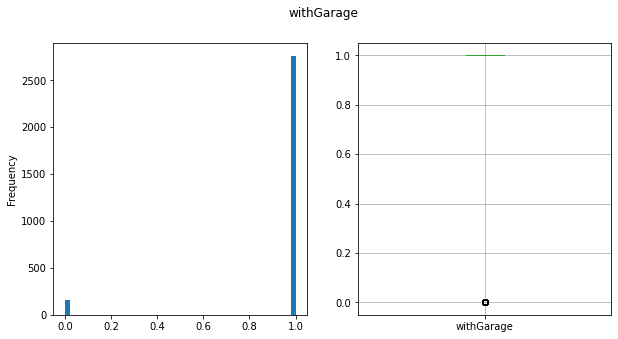

In [26]:
var_distribution('withGarage', train_test)

#### GarageFinish

Null values percentage: 0.05


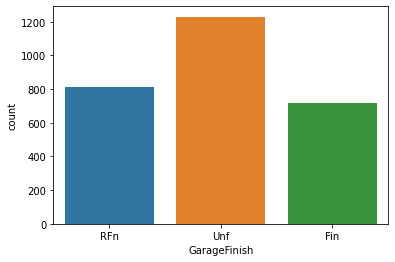

In [27]:
counts_and_nulls(train_test, 'GarageFinish')

In [28]:
train_test['GarageFinish'].fillna('NA', inplace = True)

#### GarageQual



Null values percentage: 0.05


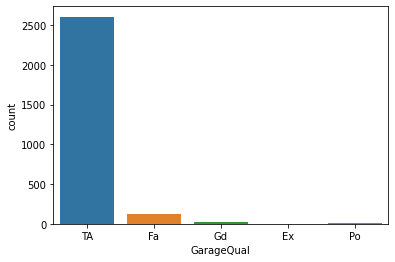

In [29]:
counts_and_nulls(train_test, 'GarageQual')

In [30]:
train_test['GarageQual'].fillna('NA', inplace = True)

#### GarageCond

Null values percentage: 0.05


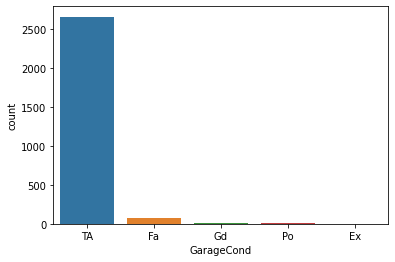

In [31]:
counts_and_nulls(train_test, 'GarageCond')

In [32]:
train_test['GarageCond'].fillna('NA', inplace = True)

#### GarageType

Null values percentage: 0.05


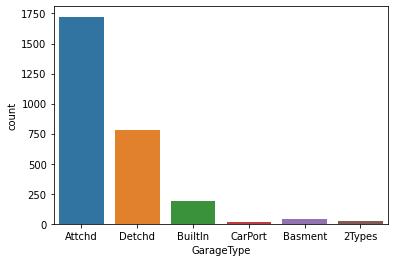

In [33]:
counts_and_nulls(train_test, 'GarageType')

In [34]:
train_test['GarageType'].fillna('NA', inplace = True)

#### BsmtExposure/ BsmtCond/ BsmtQual/ BsmtFinType2/ BsmtFinType1



BsmtExposure/ BsmtCond/ BsmtQual/ BsmtFinType2/ BsmtFinType1有空值可能跟房屋沒有Bsmt有關係。
因為95%的空值，TotalBsmtSF都是0。
所以用NA填補空值。

In [35]:
for col in ['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']:

  null = train_test[col].isnull().sum()

  print('The number of houses that {} is null and TotalBsmtSF is 0 : {}'.format(col , train_test[(train_test[col].isnull())& (train_test.TotalBsmtSF == 0)].shape[0]))
  print('Percentage: ', train_test[(train_test[col].isnull())& (train_test.TotalBsmtSF == 0)].shape[0]/ null)
  print('===================================================================')

The number of houses that BsmtExposure is null and TotalBsmtSF is 0 : 78
Percentage:  0.9512195121951219
The number of houses that BsmtCond is null and TotalBsmtSF is 0 : 78
Percentage:  0.9512195121951219
The number of houses that BsmtQual is null and TotalBsmtSF is 0 : 78
Percentage:  0.9629629629629629
The number of houses that BsmtFinType2 is null and TotalBsmtSF is 0 : 78
Percentage:  0.975
The number of houses that BsmtFinType1 is null and TotalBsmtSF is 0 : 78
Percentage:  0.9873417721518988


In [36]:
print('Empty TotalBsmtSF counts: ', train_test.TotalBsmtSF.isnull().sum())

Empty TotalBsmtSF counts:  1


In [37]:
# BsmtExposure

train_test['BsmtExposure'] = ['NA' if (x == 0) or (x == np.nan) else 'No' for x in list(train_test.TotalBsmtSF)]

#  BsmtCond

train_test['BsmtCond'] = ['NA' if (x == 0) or (x == np.nan) else 'TA' for x in list(train_test.TotalBsmtSF)]

# BsmtQual

train_test['BsmtQual'] = ['NA' if (x == 0) or (x == np.nan) else 'TA' for x in list(train_test.TotalBsmtSF)]

# BsmtFinType2

train_test['BsmtFinType2'].fillna('NA', inplace = True)

# BsmtFinType1

train_test['BsmtFinType1'].fillna('NA', inplace = True)


#### MasVnrType/ MasVnrArea

MasVnrType有空值可能跟房屋沒有Masonry veneer 有關係。 因為95%的空值，MasVnrArea空值。 所以用None填補空值。

Null values percentage: 0.01


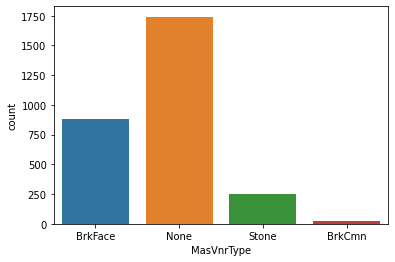

In [38]:
counts_and_nulls(train_test, 'MasVnrType')

In [39]:
null = train_test['MasVnrType'].isnull().sum()

print('The number of houses that {} is null and MasVnrArea is null/0 : {}'.format('MasVnrType' , train_test[(train_test['MasVnrType'].isnull())& (train_test.MasVnrArea.isnull())].shape[0]))
print('Percentage: ', train_test[(train_test['MasVnrType'].isnull())& (train_test.MasVnrArea.isnull())].shape[0]/ null)


The number of houses that MasVnrType is null and MasVnrArea is null/0 : 23
Percentage:  0.9583333333333334


In [40]:
# MasVnrType

train_test['MasVnrType'].fillna('None', inplace = True)


# MasVnrArea
train_test['MasVnrArea'].fillna(0, inplace = True)

#### 因為以下特徵只有少於五個空值，所以直接用median跟最常見值填補。

In [41]:
small_missing_var = list(alldf_missing[(alldf_missing.NA < 5) & (alldf_missing.NA != 0)].variable)

count = 0
for val in small_missing_var:
    
    # check type of value in each column
    data = list(train_test[val])[0]
    print('============================================')
    
    if type(data) == type('str'):
        print('This is a str data')
        most = train_test[val].value_counts().keys()[0]
        train_test[val].fillna(most, inplace = True)
        print(val, 'has been filled with ', most)
        count += 1
    elif type(data) in [np.float, np.int]:
        print('This is a numeric data')
        median = train_test[val].median()
        train_test[val].fillna(median, inplace = True)
        print(val, 'has been filled with ', median)
        count += 1
    else:
        print('Something went wrong')
        break 

#train_test.isnull().sum()
        
        
        

This is a str data
MSZoning has been filled with  RL
This is a str data
Functional has been filled with  Typ
This is a numeric data
BsmtHalfBath has been filled with  0.0
This is a numeric data
BsmtFullBath has been filled with  0.0
This is a str data
Utilities has been filled with  AllPub
This is a numeric data
GarageCars has been filled with  2.0
This is a str data
KitchenQual has been filled with  TA
This is a numeric data
BsmtFinSF1 has been filled with  368.5
This is a str data
SaleType has been filled with  WD
This is a numeric data
BsmtFinSF2 has been filled with  0.0
This is a numeric data
BsmtUnfSF has been filled with  467.0
This is a numeric data
TotalBsmtSF has been filled with  989.5
This is a str data
Exterior2nd has been filled with  VinylSd
This is a str data
Exterior1st has been filled with  VinylSd
This is a numeric data
GarageArea has been filled with  480.0
This is a str data
Electrical has been filled with  SBrkr


#### All missing data are filled

In [42]:
for col, null in zip(train_test.columns, train_test.isnull().sum()):
  if null > 0:
    print(col, null)
    break

print('All missing data are filled!')

All missing data are filled!


## Nominal Encoding

nominal variables 

In [43]:
print('nominal variables count: ', variables[variables.datatype == 0].shape[0])

nominal_variables = list(variables[variables.datatype == 0].val)

print('nominal variables : ', nominal_variables)

nominal variables count:  23
nominal variables :  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


In [44]:
## show variables that have been removed from traindf_filled dataframe

count = 0
for i in nominal_variables:
    if i not in list(train_test.columns):
        print('removed_nominal_val: ', i)
        
        nominal_variables.remove(i)
        count += 1
        
print('removed_nominal_val count: ', count)
print('new nominal variables count: ', len(nominal_variables), nominal_variables)

removed_nominal_val:  Alley
removed_nominal_val:  MiscFeature
removed_nominal_val count:  2
new nominal variables count:  21 ['MSSubClass', 'MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']


### 計算各個特徵下的subgroup個數，並將大於10個subgroups的特徵分組成manycates，10個以下的分組成fewcates

In [45]:
manycates = []
fewcates = []

for val in nominal_variables:
    #print(val+':  ')
    cates = list(train_test[val].value_counts().keys())
    
    if len(cates)> 10:
        print(val, 'has more than 10 categories which are ', len(cates))
        manycates.append(val)
        
    else:
        print(val, 'has {} categories'.format(len(cates)))
        fewcates.append(val)
        
        

    

MSSubClass has more than 10 categories which are  16
MSZoning has 5 categories
Street has 2 categories
LotConfig has 5 categories
Neighborhood has more than 10 categories which are  25
Condition1 has 9 categories
Condition2 has 8 categories
BldgType has 5 categories
HouseStyle has 8 categories
RoofStyle has 6 categories
RoofMatl has 8 categories
Exterior1st has more than 10 categories which are  15
Exterior2nd has more than 10 categories which are  16
MasVnrType has 4 categories
Foundation has 6 categories
Heating has 6 categories
CentralAir has 2 categories
Electrical has 5 categories
GarageType has 7 categories
SaleType has 9 categories
SaleCondition has 6 categories


#### fewcates用全部的subgroups作為dummmies。

In [46]:
count = 0
for val in fewcates:
    print('=================================================================')
    print(val, ':')
    dummydf = pd.get_dummies(train_test[val], drop_first=True)
    dummydf.columns = [val+'_'+name for name in list(dummydf.columns)]
    print('Before: ', len(train_test.columns))
    train_test.drop(columns = val, inplace=True)
    train_test = pd.concat([train_test, dummydf], axis = 1)
    print('After: ', len(train_test.columns), 'Dummies: ', len(dummydf.columns))
    count += 1

print('if all processed? ', count == len(fewcates))
    

MSZoning :
Before:  76
After:  79 Dummies:  4
Street :
Before:  79
After:  79 Dummies:  1
LotConfig :
Before:  79
After:  82 Dummies:  4
Condition1 :
Before:  82
After:  89 Dummies:  8
Condition2 :
Before:  89
After:  95 Dummies:  7
BldgType :
Before:  95
After:  98 Dummies:  4
HouseStyle :
Before:  98
After:  104 Dummies:  7
RoofStyle :
Before:  104
After:  108 Dummies:  5
RoofMatl :
Before:  108
After:  114 Dummies:  7
MasVnrType :
Before:  114
After:  116 Dummies:  3
Foundation :
Before:  116
After:  120 Dummies:  5
Heating :
Before:  120
After:  124 Dummies:  5
CentralAir :
Before:  124
After:  124 Dummies:  1
Electrical :
Before:  124
After:  127 Dummies:  4
GarageType :
Before:  127
After:  132 Dummies:  6
SaleType :
Before:  132
After:  139 Dummies:  8
SaleCondition :
Before:  139
After:  143 Dummies:  5
if all processed?  True


#### Manycates用前10大的subgroups作為dummies。

In [47]:
count = 0

for val in manycates:
    print('=================================================================')    
    print(val, ':')
    
    freqtop10 = list(train_test[val].value_counts().keys())[:10]
    top10dummydf = pd.get_dummies(train_test[val])[freqtop10]
    print('Shape: ', top10dummydf.shape)
    
    top10dummydf.columns = [val+'_'+str(name) for name in list(top10dummydf.columns)]
    
    print('Before: ', len(train_test.columns))
    
    train_test = pd.concat([train_test, top10dummydf], axis = 1)
    count += 1
    print('After: ', len(train_test.columns), 'dummies: ', len(top10dummydf.columns))
    
    
print('if all vars are processed ?', count == len(manycates))

MSSubClass :
Shape:  (2919, 10)
Before:  143
After:  153 dummies:  10
Neighborhood :
Shape:  (2919, 10)
Before:  153
After:  163 dummies:  10
Exterior1st :
Shape:  (2919, 10)
Before:  163
After:  173 dummies:  10
Exterior2nd :
Shape:  (2919, 10)
Before:  173
After:  183 dummies:  10
if all vars are processed ? True


In [48]:
train_test.drop(columns= manycates, inplace=True)

#### 目前有179個variables。

In [49]:
train_test.shape

(2919, 179)

## Nominal data encoding完成。

## Ordinal Encoding

#### Target guided(根據SalePrice的平均，排名) ordinal encoding 

In [50]:
print('ordinal variables count: ', variables[variables.datatype == 1].shape[0])

ordinal_variables = list(variables[variables.datatype == 1].val)

print('ordinal variables : ', ordinal_variables)


ordinal variables count:  23
ordinal variables :  ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


In [51]:
print('Removing those variables with too much(>45%) null values.')
print('Before: ', len(ordinal_variables), 'ordinal variables.')
for removed in ['FireplaceQu', 'PoolQC', 'Fence']:
    ordinal_variables.remove(removed)
    
    
print('After: ', len(ordinal_variables), 'ordinal variables.')

Removing those variables with too much(>45%) null values.
Before:  23 ordinal variables.
After:  20 ordinal variables.


In [52]:
count = 0
for val in ordinal_variables:
    print('======================================================')
    print(val, ': ')
    
    d = traindf.groupby(val)['SalePrice'].mean().rank().to_dict()
    print(d)
    
    train_test[val] = train_test[val].map(d)
    count += 1
    
    
print('If all vars are processed? ', count == len(ordinal_variables))
    
    
    

LotShape : 
{'IR1': 2.0, 'IR2': 4.0, 'IR3': 3.0, 'Reg': 1.0}
LandContour : 
{'Bnk': 1.0, 'HLS': 4.0, 'Low': 3.0, 'Lvl': 2.0}
Utilities : 
{'AllPub': 2.0, 'NoSeWa': 1.0}
LandSlope : 
{'Gtl': 1.0, 'Mod': 2.0, 'Sev': 3.0}
OverallQual : 
{1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0, 10: 10.0}
OverallCond : 
{1: 1.0, 2: 4.0, 3: 2.0, 4: 3.0, 5: 8.0, 6: 5.0, 7: 7.0, 8: 6.0, 9: 9.0}
ExterQual : 
{'Ex': 4.0, 'Fa': 1.0, 'Gd': 3.0, 'TA': 2.0}
ExterCond : 
{'Ex': 5.0, 'Fa': 2.0, 'Gd': 3.0, 'Po': 1.0, 'TA': 4.0}
BsmtQual : 
{'Ex': 4.0, 'Fa': 1.0, 'Gd': 3.0, 'TA': 2.0}
BsmtCond : 
{'Fa': 2.0, 'Gd': 4.0, 'Po': 1.0, 'TA': 3.0}
BsmtExposure : 
{'Av': 3.0, 'Gd': 4.0, 'Mn': 2.0, 'No': 1.0}
BsmtFinType1 : 
{'ALQ': 4.0, 'BLQ': 2.0, 'GLQ': 6.0, 'LwQ': 3.0, 'Rec': 1.0, 'Unf': 5.0}
BsmtFinType2 : 
{'ALQ': 6.0, 'BLQ': 1.0, 'GLQ': 4.0, 'LwQ': 2.0, 'Rec': 3.0, 'Unf': 5.0}
HeatingQC : 
{'Ex': 5.0, 'Fa': 2.0, 'Gd': 4.0, 'Po': 1.0, 'TA': 3.0}
KitchenQual : 
{'Ex': 4.0, 'Fa': 1.0, 'Gd': 3.

In [53]:
# Some ordinal cate 'NA' does not show in traindf

train_test.fillna(0, inplace = True)

## 完成 Ordinal Encoding

## 加上feature:賣出年-建造年

In [54]:
train_test['y_built_sold'] = train_test['YrSold'] - train_test['YearBuilt']

# Models


## 首先，將train_test拆回成train&test兩個datasets。

In [55]:
train_x = train_test[train_test.Id < 1461]

train_y = traindf[['SalePrice']]

print('original train dataset size: ', traindf.shape, '| train df shape: ', train_x.shape)

original train dataset size:  (1460, 81) | train df shape:  (1460, 180)


In [56]:
test = train_test[train_test.Id >= 1461]

print('original test dataset size: ', testdf.shape, '| test df shape: ', test.shape)

original test dataset size:  (1459, 80) | test df shape:  (1459, 180)


## GridSearch CV

In [57]:
import time

### Linear regression

In [ ]:
# try all 179 variables 

start = time.time()

linear = LinearRegression(n_jobs=-1)
para = {'fit_intercept':[True, False], 'normalize': [False, True]}

linear_grid = GridSearchCV(linear, param_grid=para, cv=10, n_jobs=-1, verbose=10)


linear_grid.fit(train_x.iloc[:, 1:], train_y)
print('Running time: ', (time.time()-start)/60, 'mins')

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0420s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1149s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s


Running time:  0.006930220127105713 mins


[Parallel(n_jobs=-1)]: Done  28 out of  40 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished


In [ ]:
linear_grid.best_score_

0.6789737151972315

In [ ]:
linear_grid.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
linear_best = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

score = cross_val_score(linear_best, train_x.iloc[:, 1:], train_y, cv = 10, scoring='r2')

In [ ]:
print('r2 average score of 10 cv: ', score.mean())

r2 average score of 10 cv:  0.6789737151970504


### Ridge Regression 

Submission score: 0.15600

In [70]:
start = time.time()

ridge = Ridge(random_state=99)

para = {'alpha': np.arange(0, 1, 0.01), 'normalize':[True, False], 'fit_intercept': [True, False]}

ridge_grid = GridSearchCV(ridge, cv=10, verbose=0, n_jobs=-1, param_grid=para)
ridge_grid.fit(train_x.iloc[:, 1:], train_y)

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  0.35750826199849445 mins


In [71]:
ridge_grid.best_estimator_

Ridge(alpha=0.36, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=99, solver='auto', tol=0.001)

In [72]:
ridge_grid.best_score_

0.8272250576619431

In [73]:
ridge_best = Ridge(alpha=0.36, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=99, solver='auto', tol=0.001)


ridge_best.fit(train_x.iloc[:, 1:], train_y)


Ridge(alpha=0.36, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=99, solver='auto', tol=0.001)

In [84]:
pred = ridge_best.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred.reshape(-1)})



In [85]:
# sub.to_csv('ridge_.csv', index = False)

### Lasso Regression 

Submission score: 0.16184

In [ ]:
start = time.time()

lasso = Lasso(random_state=99 ,normalize=True, fit_intercept= True)
para = {'alpha': np.arange(10, 27), 'max_iter':  np.arange(100, 150, 10),  }

lasso_grid = GridSearchCV(lasso, cv=10, n_jobs=-1, param_grid=para, verbose=0)

lasso_grid.fit(train_x.iloc[:, 1:], train_y)

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  0.1494856039683024 mins


In [ ]:
lasso_grid.best_estimator_

Lasso(alpha=24, copy_X=True, fit_intercept=True, max_iter=140, normalize=True,
      positive=False, precompute=False, random_state=99, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
lasso_grid.best_score_

0.8185830908608096

In [ ]:
lasso_best = Lasso(alpha=24, copy_X=True, fit_intercept=True, max_iter=140, normalize=True,
      positive=False, precompute=False, random_state=99, selection='cyclic',
      tol=0.0001, warm_start=False)

lasso_best.fit(train_x.iloc[:, 1:], train_y)

Lasso(alpha=24, copy_X=True, fit_intercept=True, max_iter=140, normalize=True,
      positive=False, precompute=False, random_state=99, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
pred = lasso_best.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})

sub.head()

,Id,SalePrice
1460,1461,100244.006958
1461,1462,169854.651758
1462,1463,166843.048375
1463,1464,184619.113366
1464,1465,208118.785063


In [ ]:
# sub.to_csv('lasso_.csv', index = False)

### Elastic Net

Submission score: 0.16074

In [ ]:
start = time.time()

net = ElasticNet(random_state=99, selection= 'random')

para = {'alpha':np.arange(0.1, 1.1, 0.1) , 'l1_ratio':np.arange(0.5, 1.01, 0.05), 'max_iter':[1100, 1500, 1000] }

net_grid =GridSearchCV(cv=10, param_grid=para, estimator=net, n_jobs=-1, verbose=0)

net_grid.fit(train_x.iloc[:, 1:], train_y)


print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  7.791705958048502 mins


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687381656328.7045, tolerance: 920791133.4609975
  positive)


In [ ]:
net_grid.best_estimator_

ElasticNet(alpha=0.4, copy_X=True, fit_intercept=True,
           l1_ratio=0.9500000000000004, max_iter=1500, normalize=False,
           positive=False, precompute=False, random_state=99,
           selection='random', tol=0.0001, warm_start=False)

In [ ]:
net_grid.best_score_


0.8246248030393097

In [ ]:
net_grid = ElasticNet(alpha=0.4, copy_X=True, fit_intercept=True,
           l1_ratio=0.9500000000000004, max_iter=1500, normalize=False,
           positive=False, precompute=False, random_state=99,
           selection='random', tol=0.0001, warm_start=False)

net_grid.fit(train_x.iloc[:, 1:], train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687381656328.7045, tolerance: 920791133.4609975
  positive)


ElasticNet(alpha=0.4, copy_X=True, fit_intercept=True,
           l1_ratio=0.9500000000000004, max_iter=1500, normalize=False,
           positive=False, precompute=False, random_state=99,
           selection='random', tol=0.0001, warm_start=False)

In [ ]:
pred = net_grid.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})

sub.head()

,Id,SalePrice
1460,1461,94278.565479
1461,1462,167090.369395
1462,1463,167986.050430
1463,1464,182314.723807
1464,1465,210625.948794


In [ ]:
# sub.to_csv('net2_.csv', index = False)

### Decision Tree

Submission score: 0.20766

In [ ]:
start = time.time()

decision_tree = DecisionTreeRegressor( random_state= 99 )

para = {'max_leaf_nodes': np.arange(40, 90, 10), 'max_features':['auto', 'sqrt', 'log2'], 'max_depth': np.arange(10, 20), 'min_samples_leaf': [1, 3, 5], 'min_samples_split': [2, 5, 3]}

decision_tree_grid = GridSearchCV(decision_tree, param_grid= para, cv=10, n_jobs=-1, verbose=0)

decision_tree_grid.fit(train_x, train_y)
                             

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  1.3652158617973327 mins


In [ ]:
decision_tree_grid.best_score_

0.7727894025643653

In [ ]:
decision_tree_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=60,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=99, splitter='best')

In [ ]:
decision_tree = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=60,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=99, splitter='best')

In [ ]:
decision_tree.fit(train_x.iloc[:, 1:], train_y)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=60,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=99, splitter='best')

In [ ]:
pred = decision_tree.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})


In [ ]:
# sub.to_csv('decision_tree_.csv', index = False)

### Random Forest

Submission score: 0.15435

In [ ]:
start = time.time()

random_forest = RandomForestRegressor(random_state=62, bootstrap=True, oob_score=True, n_jobs=-1)

para = {'n_estimators': np.arange(100, 600, 50), 'max_depth': np.arange(5, 15), 'min_samples_split': [2, 5, 7, 3]}

random_forest_grid_3 = RandomizedSearchCV(random_forest, cv=5, n_jobs=-1, verbose=0, param_distributions=para, random_state= 99)

random_forest_grid_3.fit(train_x.iloc[:, 1:]  , np.array(train_y).reshape(train_x.shape[0], ))

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  1.742113995552063 mins


In [ ]:
random_forest_grid_3.best_score_

0.8563477327045519

In [ ]:
random_forest_grid_3.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=62, verbose=0, warm_start=False)

In [ ]:
random_forest_best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=62, verbose=0, warm_start=False)

random_forest_best.fit(train_x.iloc[:, 1:]  , np.array(train_y).reshape(train_x.shape[0], ))


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=62, verbose=0, warm_start=False)

In [ ]:
pred = random_forest_best.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})


In [ ]:
# sub.to_csv('random_forest2_.csv', index = False)

## Adaboost

In [ ]:
start = time.time()

adaboost = AdaBoostRegressor( loss='exponential', random_state=99)

para = {'n_estimators':np.arange(50, 160, 10), 'learning_rate': np.arange(0.1, 1, 0.1)}

adaboost_grid = RandomizedSearchCV(adaboost,  cv=10, n_jobs=-1, param_distributions= para, verbose=0, random_state= 99)
adaboost_grid.fit(train_x.iloc[:, 1:], np.array(train_y).reshape(train_x.shape[0], ))

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  0.6942663272221883 mins


In [ ]:
adaboost_grid.best_params_

{'learning_rate': 0.30000000000000004, 'n_estimators': 130}

In [ ]:
adaboost_grid.best_score_

0.8093779480519065

##  Gradient Boosting

Submission score: 0.13324

In [106]:
start = time.time()

grad_b = GradientBoostingRegressor(random_state= 99, learning_rate= 0.189, max_depth= 8, max_leaf_nodes= 16, n_estimators=150, )

para = {'min_samples_split': [15, 20, 25, 30, 35],  'min_impurity_decrease': np.arange(1, 2, 0.1)}

grad_b_rand = RandomizedSearchCV(grad_b, cv=10, n_jobs=-1, param_distributions=para, verbose=0, random_state= 99)

grad_b_rand.fit(train_x.iloc[:, 1:],  np.array(train_y).reshape(train_x.shape[0], ))

print('Running time: ', (time.time()-start)/60, 'mins')

Running time:  1.39878005584081 mins


In [107]:
grad_b_rand.best_params_

{'min_impurity_decrease': 1.8000000000000007, 'min_samples_split': 35}

In [108]:
grad_b_rand.best_score_

0.8999229625416929

In [109]:
grad_b_rand.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.189, loss='ls',
                          max_depth=8, max_features=None, max_leaf_nodes=16,
                          min_impurity_decrease=1.8000000000000007,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=35, min_weight_fraction_leaf=0.0,
                          n_estimators=150, n_iter_no_change=None,
                          presort='deprecated', random_state=99, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [110]:
grad_b_rand = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.189, loss='ls',
                          max_depth=8, max_features=None, max_leaf_nodes=16,
                          min_impurity_decrease=1.8000000000000007,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=35, min_weight_fraction_leaf=0.0,
                          n_estimators=150, n_iter_no_change=None,
                          presort='deprecated', random_state=99, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

grad_b_rand.fit(train_x.iloc[:, 1:],  np.array(train_y).reshape(train_x.shape[0], ))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.189, loss='ls',
                          max_depth=8, max_features=None, max_leaf_nodes=16,
                          min_impurity_decrease=1.8000000000000007,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=35, min_weight_fraction_leaf=0.0,
                          n_estimators=150, n_iter_no_change=None,
                          presort='deprecated', random_state=99, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [111]:
pred = grad_b_rand.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})


In [112]:
# sub.to_csv('grad_b2_.csv', index = False)

## XGBoost

## Submission score: 0.13048, Kaggle 排名1763/ 4818, 前37%



In [58]:
start = time.time()

xgb_model = xgb.XGBRegressor(seed = 99, tree_method='gpu_hist', n_jobs=-1, random_state= 99 ,  max_depth = 5, colsample_bytree = 0.6, gamma =  3, learning_rate=0.18999999999999995, n_estimators=100)

para = {'reg_alpha': np.arange(0.15, 0.3, 0.01), 'reg_lambda': [1, 3, 5, 7] , 'subsample':np.arange(0.1, 1, 0.1) , 'booster': ['gbtree', 'gblinear', 'dart']}

xgb_random = RandomizedSearchCV(xgb_model, cv=10, n_jobs=-1, param_distributions=para, verbose=0, random_state= 99)

xgb_random.fit(train_x.iloc[:, 1:], train_y)

print('Running time: ', (time.time()-start)/60, 'mins')

[06:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Running time:  0.7607340455055237 mins


In [59]:
xgb_random.best_score_

0.8832500466501632

In [ ]:
xgb_random.best_estimator_

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=3,
             importance_type='gain', learning_rate=0.18999999999999995,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=99, reg_alpha=0.18000000000000002, reg_lambda=7,
             scale_pos_weight=1, seed=99, silent=None,
             subsample=0.7000000000000001, tree_method='gpu_hist', verbosity=1)

In [60]:
xgb_model2 = xgb.XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=3,
             importance_type='gain', learning_rate=0.18999999999999995,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=99, reg_alpha=0.18000000000000002, reg_lambda=7,
             scale_pos_weight=1, seed=99, silent=None,
             subsample=0.7000000000000001, tree_method='gpu_hist', verbosity=1)

xgb_model2.fit(train_x.iloc[:, 1:], train_y)

[06:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=3,
             importance_type='gain', learning_rate=0.18999999999999995,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=99, reg_alpha=0.18000000000000002, reg_lambda=7,
             scale_pos_weight=1, seed=99, silent=None,
             subsample=0.7000000000000001, tree_method='gpu_hist', verbosity=1)

In [ ]:
pred = xgb_model2.predict(test.iloc[:, 1:])


sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})

# sub.to_csv('xgb_2.csv', index = False)

## Importance Plot

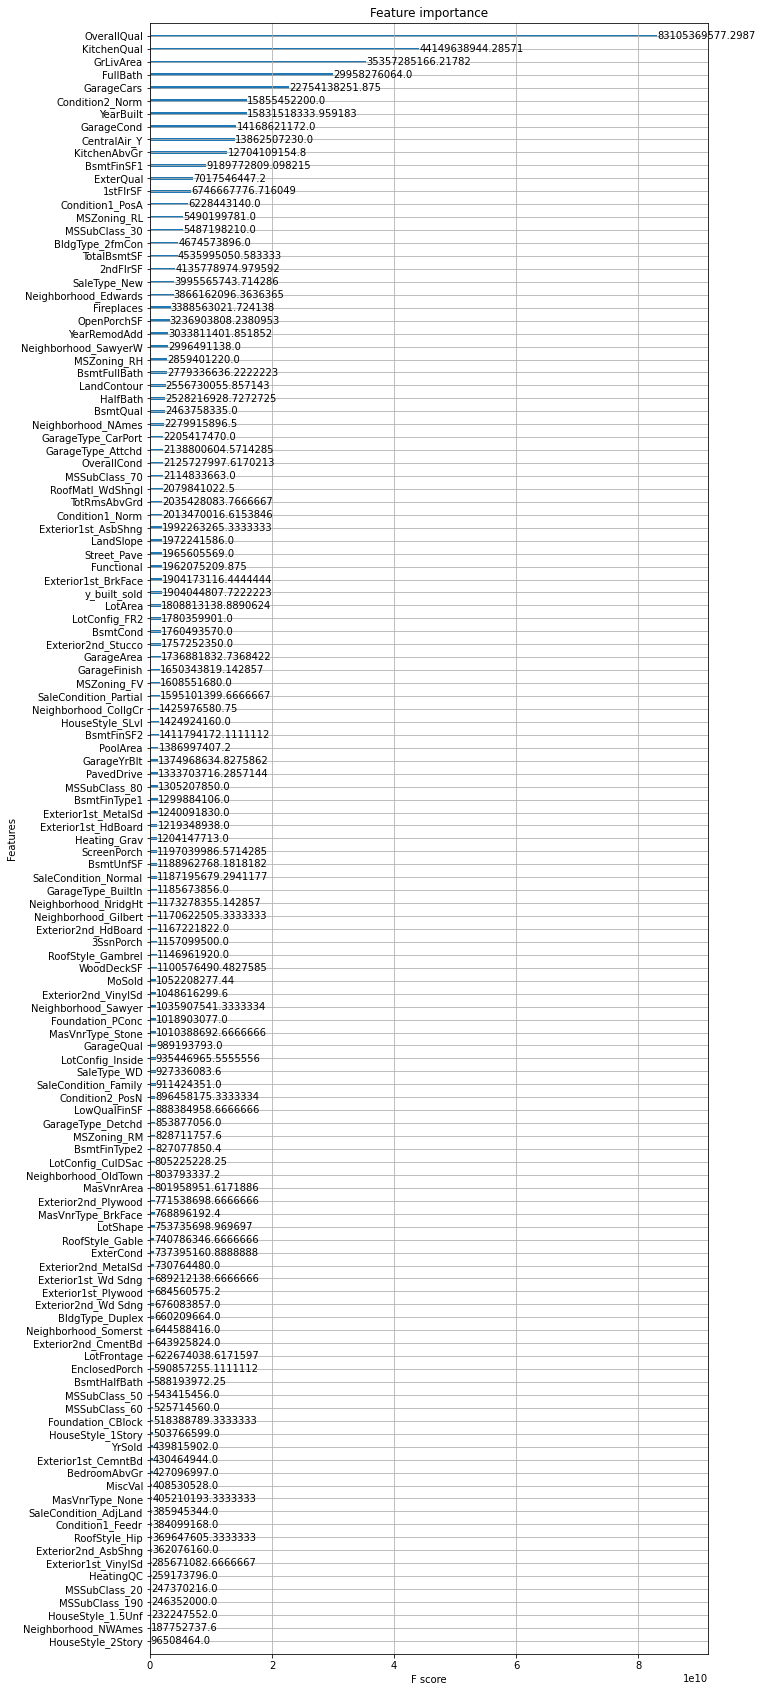

In [64]:
f = plt.figure(figsize = (10, 30))
ax = f.add_subplot(111)

xgb.plot_importance(xgb_model2, ax=ax, importance_type='gain')

plt.show()

## Xgboost First Tree Plot

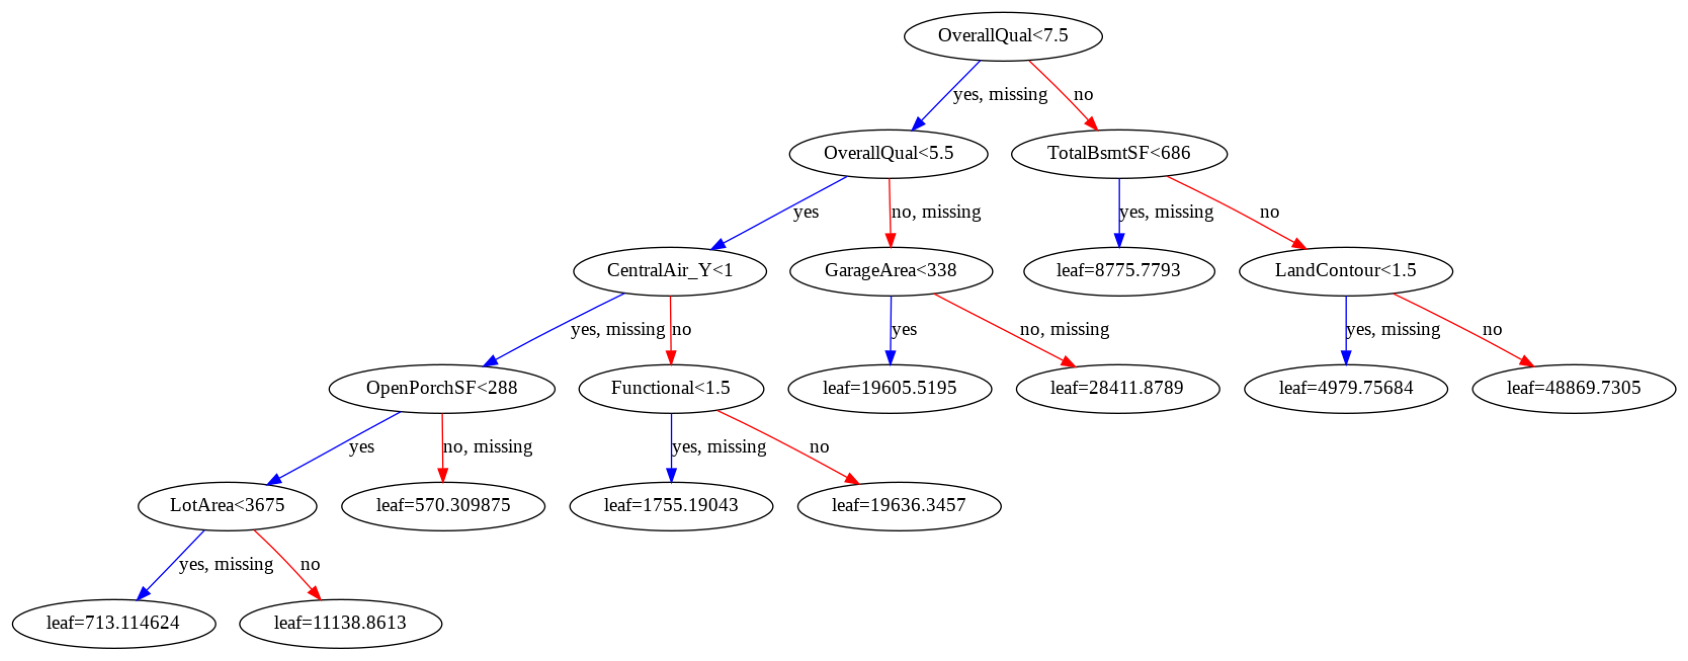

In [69]:
f = plt.figure(figsize = (30, 100))
ax = f.add_subplot(111)

xgb.plot_tree(booster=xgb_model2, num_trees=1, ax=ax)
plt.show()

# 總結

Ridge, Lasso, Elastic Net, Decision Tree, Random Forest, Adaboost, Gradient Boosting, XGBoost模型, Kaggle分數比較 

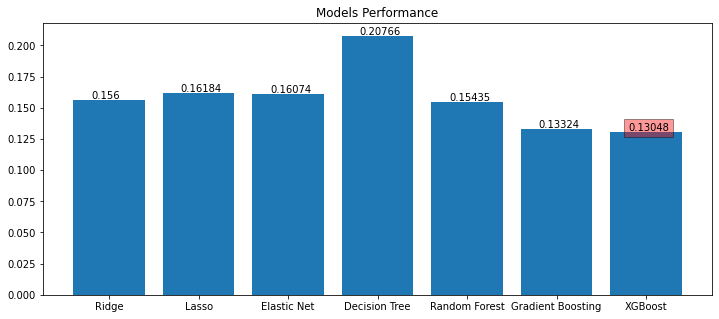

In [132]:
performance = {'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'], 'score': [0.15600, 0.16184, 0.16074, 0.20766, 0.15435, 0.13324, 0.13048 ]}

plt.figure(figsize = (12, 5))
plt.bar(x = performance['Model'], height= performance['score'], )

for i in range(len(performance['score'])):
  if i == 6:
    plt.text(-0.2 + i , performance['score'][i]+0.001, s = performance['score'][i], bbox=dict(facecolor='red', alpha=0.4))
    
  else:
    plt.text(-0.2 + i , performance['score'][i]+0.001, s = performance['score'][i])

plt.title('Models Performance')
plt.show()